In [229]:
from IPython.core.display import display, HTML
display(HTML('<style>.container{width:95% !important;}</style>'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime as dt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.tree import plot_tree, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm

In [35]:
def days_between(d1, d2):
    d1 = dt.strptime(d1, "%Y-%m-%d")
    d2 = dt.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

In [14]:
raw_ds = pd.read_csv('Dataset.csv', sep=';')

C:\Users\Lex\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (1,3,4,5,6,7,8,11,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
raw_ds = raw_ds[~raw_ds['ID клиента'].isna()] #очистка от мусора

In [16]:
raw_ds

,ID клиента,Пол,Возраст,Город,Дата поступления жалобы,Дата закрытия жалобы,Тематика жалобы,Канал поступления жалобы,Продукт,Запрашиваемая сумма возмещения,Сумма выплаты клиенту,Тип подарка,CSI,Комментарий к CSI
0,1.0,F,21.0,Москва,02.03.2019,03.03.2019,Доставка,Отделение,Перевод,4313.0,4313.0,Промокод,8.0,NaN
1,2.0,M,36.0,Санкт-Петербург,31.03.2019,01.04.2019,Доставка,Колл-центр,Кредитная карта,1229.0,1229.0,Бонусы,10.0,NaN
2,3.0,M,36.0,Нижний Нивгород,08.03.2019,09.03.2019,Доставка,Колл-центр,Кредитная карта,332.0,332.0,NaN,7.0,NaN
3,4.0,F,36.0,Уфа,22.03.2019,23.03.2019,Доставка,Колл-центр,Кредитная карта,2127.0,2127.0,NaN,2.0,хамство в отделенит
4,5.0,F,36.0,Саров,21.03.2019,22.03.2019,Доставка,Колл-центр,Кредитная карта,1165.0,1165.0,NaN,7.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9035,9036.0,M,51.0,Санкт-Петербург,21.03.2019,22.03.2019,Доставка,Отделение,Перевод,3637.0,3528.0,Физический,5.0,NaN
9036,9037.0,M,50.0,Нижний Нивгород,12.03.2019,13.03.2019,Комиссия,Колл-центр,Кредитная карта,2696.0,2616.0,NaN,4.0,NaN
9037,9038.0,M,32.0,Подольск,30.03.2019,31.03.2019,Комиссия,Колл-центр,Кредитная карта,911.0,857.0,Промокод,1.0,NaN
9038,9039.0,M,39.0,Москва,15.03.2019,16.03.2019,Доставка,Отделение,Перевод,2459.0,2214.0,NaN,5.0,NaN


## Гипотезы

1) Тип подарка влияет на CSI

2) % выплаты влияет на CSI

3) Время ожидания влияет на CSI

4) Возраст влияет на CSI

5) Город \ тип города влияет на CSI

## Идеи

**для лучшей интерпретации построить дерево  решений, возможно, переобученное** 

**влияние различных показателей оценивается через анализ значимости весов в модели линейной регрессии**

In [18]:
raw_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9040 entries, 0 to 9039
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID клиента                      9040 non-null   float64
 1   Пол                             8920 non-null   object 
 2   Возраст                         9040 non-null   float64
 3   Город                           9040 non-null   object 
 4   Дата поступления жалобы         9037 non-null   object 
 5   Дата закрытия жалобы            9039 non-null   object 
 6   Тематика жалобы                 9040 non-null   object 
 7   Канал поступления жалобы        9040 non-null   object 
 8   Продукт                         9040 non-null   object 
 9   Запрашиваемая сумма возмещения  9040 non-null   float64
 10  Сумма выплаты клиенту           9040 non-null   float64
 11  Тип подарка                     3477 non-null   object 
 12  CSI                             90

In [19]:
raw_ds.describe()

,ID клиента,Возраст,Запрашиваемая сумма возмещения,Сумма выплаты клиенту,CSI
count,9040.00000,9040.000000,9040.000000,9040.000000,9040.000000
mean,4520.50000,40.960177,2262.620465,2154.383850,5.639381
std,2609.76755,10.933979,1140.369082,1090.007929,2.881139
min,1.00000,21.000000,300.000000,274.000000,1.000000
25%,2260.75000,32.000000,1296.750000,1228.000000,3.000000
50%,4520.50000,40.000000,2261.500000,2147.000000,6.000000
75%,6780.25000,50.000000,3216.000000,3063.000000,8.000000
max,9040.00000,64.000000,4994.000000,4988.000000,10.000000


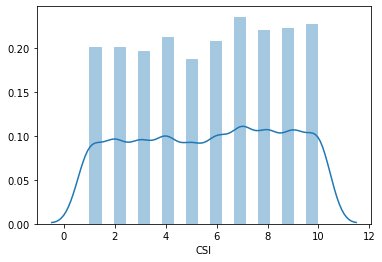

In [17]:
sns.distplot(raw_ds.CSI)

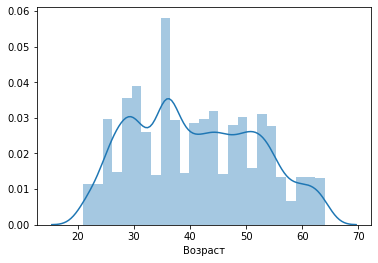

In [26]:
sns.distplot(raw_ds['Возраст'])

In [25]:
raw_ds.groupby(raw_ds['Пол']).count()

,ID клиента,Возраст,Город,Дата поступления жалобы,Дата закрытия жалобы,Тематика жалобы,Канал поступления жалобы,Продукт,Запрашиваемая сумма возмещения,Сумма выплаты клиенту,Тип подарка,CSI,Комментарий к CSI
Пол,,,,,,,,,,,,,
F,4440,4440,4440,4438,4439,4440,4440,4440,4440,4440,1722,4440,4
M,4480,4480,4480,4479,4480,4480,4480,4480,4480,4480,1709,4480,1


In [28]:
pd.value_counts(raw_ds['Пол'])

M    4480
F    4440
Name: Пол, dtype: int64

In [29]:
pd.value_counts(raw_ds['Город'])

Москва              1362
Нижний Нивгород     1356
Подольск            1129
Уфа                 1129
Набережные челны     904
Санкт-Петербург      904
Таганрог             903
Саров                677
Новый Уренгой        676
Name: Город, dtype: int64

In [30]:
pd.value_counts(raw_ds['Продукт'])

Кредитная карта    4812
Перевод            4228
Name: Продукт, dtype: int64

## Создаём рабочую копию и начинаем изменения

In [101]:
ds1 = raw_ds.copy() #создаём аналитическую копию

In [102]:
ds1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9040 entries, 0 to 9039
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID клиента                      9040 non-null   float64
 1   Пол                             8920 non-null   object 
 2   Возраст                         9040 non-null   float64
 3   Город                           9040 non-null   object 
 4   Дата поступления жалобы         9037 non-null   object 
 5   Дата закрытия жалобы            9039 non-null   object 
 6   Тематика жалобы                 9040 non-null   object 
 7   Канал поступления жалобы        9040 non-null   object 
 8   Продукт                         9040 non-null   object 
 9   Запрашиваемая сумма возмещения  9040 non-null   float64
 10  Сумма выплаты клиенту           9040 non-null   float64
 11  Тип подарка                     3477 non-null   object 
 12  CSI                             90

In [103]:
ds1['Пол'].fillna('M', inplace=True) #очень тупо, кое-кто эту методологию успешно использует:)

In [122]:
ds1.drop(index= list(ds1[ds1['Дата поступления жалобы'].isna()].index), inplace=True)

In [128]:
ds1['Тип подарка'].fillna('Отсутствует', inplace=True)

In [135]:
ds1.drop(columns=['Комментарий к CSI'], inplace=True) #малоинформативен

In [138]:
f = lambda x: dt.strptime(x, '%d-%m-%Y')
r = lambda x: str(x).replace('.', '-')
ds1['Дата поступления жалобы'] = (ds1['Дата поступления жалобы'].apply(r)).apply(f)
ds1['Дата закрытия жалобы'] = (ds1['Дата закрытия жалобы'].apply(r)).apply(f)

In [154]:
ds1['Период'] = (ds1['Дата закрытия жалобы'] - ds1['Дата поступления жалобы']).astype(np.int64)/86400000000000

In [157]:
ds1['Период'].value_counts()

1.0     7192
5.0      902
4.0      595
2.0      345
12.0       1
7.0        1
3.0        1
Name: Период, dtype: int64

In [160]:
ds1['Штраф'] = ds1['Запрашиваемая сумма возмещения'] - ds1['Сумма выплаты клиенту'] #с занижением суммы, возможно, связан CSI

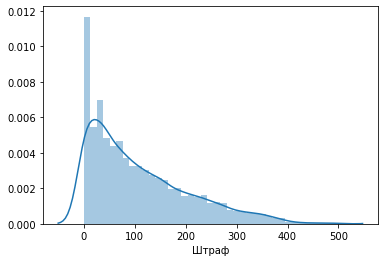

In [162]:
sns.distplot(ds1['Штраф'])

In [161]:
ds1

,ID клиента,Пол,Возраст,Город,Дата поступления жалобы,Дата закрытия жалобы,Тематика жалобы,Канал поступления жалобы,Продукт,Запрашиваемая сумма возмещения,Сумма выплаты клиенту,Тип подарка,CSI,Период,Штраф
0,1.0,F,21.0,Москва,2019-03-02,2019-03-03,Доставка,Отделение,Перевод,4313.0,4313.0,Промокод,8.0,1.0,0.0
1,2.0,M,36.0,Санкт-Петербург,2019-03-31,2019-04-01,Доставка,Колл-центр,Кредитная карта,1229.0,1229.0,Бонусы,10.0,1.0,0.0
2,3.0,M,36.0,Нижний Нивгород,2019-03-08,2019-03-09,Доставка,Колл-центр,Кредитная карта,332.0,332.0,Отсутствует,7.0,1.0,0.0
3,4.0,F,36.0,Уфа,2019-03-22,2019-03-23,Доставка,Колл-центр,Кредитная карта,2127.0,2127.0,Отсутствует,2.0,1.0,0.0
4,5.0,F,36.0,Саров,2019-03-21,2019-03-22,Доставка,Колл-центр,Кредитная карта,1165.0,1165.0,Отсутствует,7.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9035,9036.0,M,51.0,Санкт-Петербург,2019-03-21,2019-03-22,Доставка,Отделение,Перевод,3637.0,3528.0,Физический,5.0,1.0,109.0
9036,9037.0,M,50.0,Нижний Нивгород,2019-03-12,2019-03-13,Комиссия,Колл-центр,Кредитная карта,2696.0,2616.0,Отсутствует,4.0,1.0,80.0
9037,9038.0,M,32.0,Подольск,2019-03-30,2019-03-31,Комиссия,Колл-центр,Кредитная карта,911.0,857.0,Промокод,1.0,1.0,54.0
9038,9039.0,M,39.0,Москва,2019-03-15,2019-03-16,Доставка,Отделение,Перевод,2459.0,2214.0,Отсутствует,5.0,1.0,245.0


In [163]:
ds1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9037 entries, 0 to 9039
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ID клиента                      9037 non-null   float64       
 1   Пол                             9037 non-null   object        
 2   Возраст                         9037 non-null   float64       
 3   Город                           9037 non-null   object        
 4   Дата поступления жалобы         9037 non-null   datetime64[ns]
 5   Дата закрытия жалобы            9037 non-null   datetime64[ns]
 6   Тематика жалобы                 9037 non-null   object        
 7   Канал поступления жалобы        9037 non-null   object        
 8   Продукт                         9037 non-null   object        
 9   Запрашиваемая сумма возмещения  9037 non-null   float64       
 10  Сумма выплаты клиенту           9037 non-null   float64       
 11  Тип 

In [164]:
ds2 = ds1.copy()

In [167]:
#удаляем линейно зависимые и нерелевантные столбцы
ds2.drop(columns=['Дата поступления жалобы', 'Дата закрытия жалобы', 'ID клиента', 'Сумма выплаты клиенту'], inplace=True)

In [177]:
labels = ds2['CSI']

In [179]:
ds2.drop(columns='CSI', inplace=True)

In [180]:
ds2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9037 entries, 0 to 9039
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Пол                             9037 non-null   object 
 1   Возраст                         9037 non-null   float64
 2   Город                           9037 non-null   object 
 3   Тематика жалобы                 9037 non-null   object 
 4   Канал поступления жалобы        9037 non-null   object 
 5   Продукт                         9037 non-null   object 
 6   Запрашиваемая сумма возмещения  9037 non-null   float64
 7   Тип подарка                     9037 non-null   object 
 8   Период                          9037 non-null   float64
 9   Штраф                           9037 non-null   float64
dtypes: float64(4), object(6)
memory usage: 776.6+ KB


In [181]:
categorical = list(ds2.dtypes[ds2.dtypes == "object"].index)

In [182]:
categorical

['Пол',
 'Город',
 'Тематика жалобы',
 'Канал поступления жалобы',
 'Продукт',
 'Тип подарка']

In [183]:
numeric = list((ds2.select_dtypes([np.number])).columns)

In [184]:
numeric

['Возраст', 'Запрашиваемая сумма возмещения', 'Период', 'Штраф']

In [185]:
labels

0        8.0
1       10.0
2        7.0
3        2.0
4        7.0
        ... 
9035     5.0
9036     4.0
9037     1.0
9038     5.0
9039     8.0
Name: CSI, Length: 9037, dtype: float64

In [199]:
X_train, X_test, y_train, y_test = train_test_split(ds2, labels, test_size=0.3, random_state=42)

In [216]:
ds_to_plot = X_train.copy()
ds_to_plot['CSI'] = y_train

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000214D1F69128>,
      dtype=object)

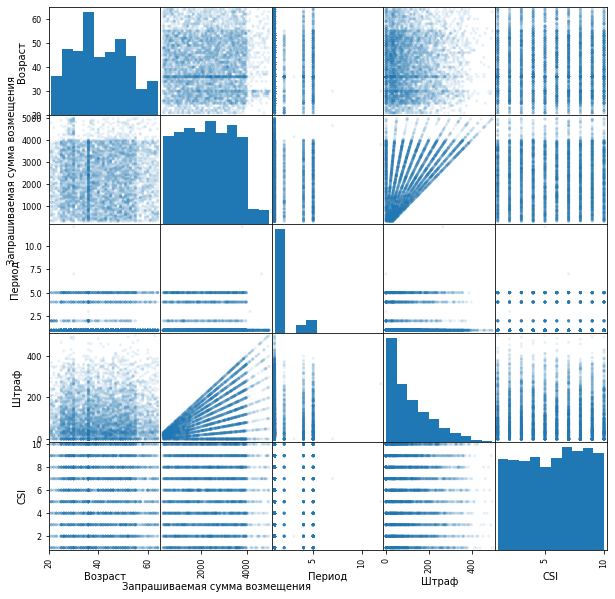

In [217]:
pd.plotting.scatter_matrix(ds_to_plot, figsize=(10,10), alpha=0.1)

### <font color = 'red'> Ни один числовой признак не коррелирует с целевой переменной, возникает впечатление, что меня обманывают </font>

In [221]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical)])

In [222]:
column_transformer.fit_transform(X_train)

<6325x21 sparse matrix of type '<class 'numpy.float64'>'
	with 37950 stored elements in Compressed Sparse Row format>

In [225]:
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

In [226]:
model = pipeline.fit(X_train, y_train)

In [228]:
y_pred = model.predict(X_test)

In [47]:
ds1['Date_diff'] = ds1.apply(days_between(ds1['Дата закрытия жалобы'], ds1['Дата поступления жалобы']), axis=0, result_type='broadcast')

TypeError: strptime() argument 1 must be str, not Series

In [ ]:
ds1['Date_diff'] = ds1.apply(days_between(ds1['Дата закрытия жалобы'], ds1['Дата поступления жалобы']))

In [65]:
f = lambda x: dt.strptime(x, '%d-%m-%Y')
r = lambda x: str(x).replace('.', '-')
ds1['d1'] = (ds1['Дата поступления жалобы'].apply(r)).apply(f)
ds1['d2'] = (ds1['Дата закрытия жалобы'].apply(r)).apply(f)

ValueError: time data 'nan' does not match format '%d-%m-%Y'

In [60]:
r(ds1['Дата закрытия жалобы'][2])

'09-03-2019'

In [78]:
ds1

,ID клиента,Пол,Возраст,Город,Дата поступления жалобы,Дата закрытия жалобы,Тематика жалобы,Канал поступления жалобы,Продукт,Запрашиваемая сумма возмещения,Сумма выплаты клиенту,Тип подарка,CSI,Комментарий к CSI
0,1.0,F,21.0,Москва,02.03.2019,03.03.2019,Доставка,Отделение,Перевод,4313.0,4313.0,Промокод,8.0,NaN
1,2.0,M,36.0,Санкт-Петербург,31.03.2019,01.04.2019,Доставка,Колл-центр,Кредитная карта,1229.0,1229.0,Бонусы,10.0,NaN
2,3.0,M,36.0,Нижний Нивгород,08.03.2019,09.03.2019,Доставка,Колл-центр,Кредитная карта,332.0,332.0,NaN,7.0,NaN
3,4.0,F,36.0,Уфа,22.03.2019,23.03.2019,Доставка,Колл-центр,Кредитная карта,2127.0,2127.0,NaN,2.0,хамство в отделенит
4,5.0,F,36.0,Саров,21.03.2019,22.03.2019,Доставка,Колл-центр,Кредитная карта,1165.0,1165.0,NaN,7.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9035,9036.0,M,51.0,Санкт-Петербург,21.03.2019,22.03.2019,Доставка,Отделение,Перевод,3637.0,3528.0,Физический,5.0,NaN
9036,9037.0,M,50.0,Нижний Нивгород,12.03.2019,13.03.2019,Комиссия,Колл-центр,Кредитная карта,2696.0,2616.0,NaN,4.0,NaN
9037,9038.0,M,32.0,Подольск,30.03.2019,31.03.2019,Комиссия,Колл-центр,Кредитная карта,911.0,857.0,Промокод,1.0,NaN
9038,9039.0,M,39.0,Москва,15.03.2019,16.03.2019,Доставка,Отделение,Перевод,2459.0,2214.0,NaN,5.0,NaN


In [87]:
OneHotEncoder?

In [98]:
ohe = OneHotEncoder(handle_unknown='ignore')

In [89]:
X = [['Male', 1], ['Female', 3], ['Female', 2]]

In [90]:
X

[['Male', 1], ['Female', 3], ['Female', 2]]

In [91]:
ohe.fit(X)

OneHotEncoder(handle_unknown='ignore')

In [93]:
ohe.categories_

[array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]

In [232]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical)])

In [100]:
column_transformer

ColumnTransformer(transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'),
                                 ['Пол', 'Город', 'Дата поступления жалобы',
                                  'Дата закрытия жалобы', 'Тематика жалобы',
                                  'Канал поступления жалобы', 'Продукт',
                                  'Тип подарка', 'Комментарий к CSI'])])

In [230]:
pd.factorize?

In [231]:
OneHotEncoder?

In [238]:
X_train

,Пол,Возраст,Город,Тематика жалобы,Канал поступления жалобы,Продукт,Запрашиваемая сумма возмещения,Тип подарка,Период,Штраф
323,M,36.0,Уфа,Доставка,Колл-центр,Кредитная карта,2103.0,Отсутствует,1.0,105.0
2034,F,29.0,Москва,Комиссия,Отделение,Перевод,4895.0,Отсутствует,1.0,489.0
996,M,51.0,Новый Уренгой,Доставка,Отделение,Перевод,1386.0,Отсутствует,4.0,27.0
8930,F,43.0,Уфа,Комиссия,Отделение,Перевод,418.0,Бонусы,1.0,8.0
7623,F,51.0,Нижний Нивгород,Доставка,Отделение,Перевод,614.0,Промокод,1.0,24.0
...,...,...,...,...,...,...,...,...,...,...
5737,F,58.0,Набережные челны,Комиссия,Колл-центр,Кредитная карта,2160.0,Отсутствует,1.0,194.0
5194,M,52.0,Подольск,Комиссия,Колл-центр,Кредитная карта,616.0,Отсутствует,1.0,24.0
5393,M,54.0,Нижний Нивгород,Доставка,Колл-центр,Кредитная карта,3414.0,Отсутствует,1.0,238.0
862,F,40.0,Таганрог,Комиссия,Колл-центр,Кредитная карта,1648.0,Отсутствует,5.0,65.0


In [255]:
ohe1 = OneHotEncoder(handle_unknown='ignore')
lal = ohe.fit(X_train[categorical])

In [257]:
lal.get_feature_names()

array(['x0_F', 'x0_M', 'x1_Москва', 'x1_Набережные челны',
       'x1_Нижний Нивгород', 'x1_Новый Уренгой', 'x1_Подольск',
       'x1_Санкт-Петербург', 'x1_Саров', 'x1_Таганрог', 'x1_Уфа',
       'x2_Доставка', 'x2_Комиссия', 'x3_Колл-центр', 'x3_Отделение',
       'x4_Кредитная карта', 'x4_Перевод', 'x5_Бонусы', 'x5_Отсутствует',
       'x5_Промокод', 'x5_Физический'], dtype=object)

In [259]:
lal.categories_

[array(['F', 'M'], dtype=object),
 array(['Москва', 'Набережные челны', 'Нижний Нивгород', 'Новый Уренгой',
        'Подольск', 'Санкт-Петербург', 'Саров', 'Таганрог', 'Уфа'],
       dtype=object),
 array(['Доставка', 'Комиссия'], dtype=object),
 array(['Колл-центр', 'Отделение'], dtype=object),
 array(['Кредитная карта', 'Перевод'], dtype=object),
 array(['Бонусы', 'Отсутствует', 'Промокод', 'Физический'], dtype=object)]

In [269]:
droplist = []
for i in lal.categories_:
    droplist.append(i[0])

In [270]:
droplist

['F', 'Москва', 'Доставка', 'Колл-центр', 'Кредитная карта', 'Бонусы']

In [262]:
oh = lal.transform(X_train[categorical]).toarray()

In [263]:
X_train_tr = pd.DataFrame(oh, columns=lal.get_feature_names())

In [278]:
X_train_tr.index = X_train.index

In [272]:
#избавимся от линейной зависимости, удалим по признаку
X_train_tr.drop(columns=['x0_F', 'x1_Москва', 'x2_Доставка', 'x3_Колл-центр', 'x4_Кредитная карта', 'x5_Бонусы'], inplace=True)

In [281]:
X_train_tr[numeric] = X_train[numeric]

In [282]:
X_train_tr

,x0_M,x1_Набережные челны,x1_Нижний Нивгород,x1_Новый Уренгой,x1_Подольск,x1_Санкт-Петербург,x1_Саров,x1_Таганрог,x1_Уфа,x2_Комиссия,x3_Отделение,x4_Перевод,x5_Отсутствует,x5_Промокод,x5_Физический,Возраст,Запрашиваемая сумма возмещения,Период,Штраф
323,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,36.0,2103.0,1.0,105.0
2034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,29.0,4895.0,1.0,489.0
996,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,51.0,1386.0,4.0,27.0
8930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,43.0,418.0,1.0,8.0
7623,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,51.0,614.0,1.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5737,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,58.0,2160.0,1.0,194.0
5194,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,52.0,616.0,1.0,24.0
5393,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,54.0,3414.0,1.0,238.0
862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,40.0,1648.0,5.0,65.0


In [285]:
X_reg = sm.add_constant(X_train_tr)
res = sm.OLS(y_train, X_reg).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CSI   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     3.613
Date:                Wed, 11 Nov 2020   Prob (F-statistic):           3.38e-07
Time:                        21:08:00   Log-Likelihood:                -15636.
No. Observations:                6325   AIC:                         3.131e+04
Df Residuals:                    6306   BIC:                         3.144e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              5.8646      0.251     23.349      0.000       5.372       6.357
x0_M                              -0.0371      0.072     -0.514      0.607      -0.179       0.105
x1_Набережные челны                0.0301      0.151      0.200      0.842      -0.265       0.326
x1_Нижний Нивгород                -0.1180      0.137     -0.858      0.391      -0.387       0.152
x1_Новый Уренгой                  -0.2985      0.325     -0.920      0.358      -0.935       0.338
x1_Подольск                        0.1460      0.142      1.032      0.302      -0.131       0.423
x1_Санкт-Петербург                 0.0168      0.150      0.112      0.911      -0.277       0.310
x1_Саров                           0.1181      0.165      0.714      0.475      -0.206       0.442
x1_Таганрог                       -0.6796      0.443     -1.533      0.125      -1.548       0.189
x1_Уфа                            -0.2141      0.142     -1.510      0.131      -0.492       0.064
x2_Комиссия                       -0.1205      0.075     -1.611      0.107      -0.267       0.026
x3_Отделение                      -0.0220      0.036     -0.607      0.544      -0.093       0.049
x4_Перевод                        -0.0220      0.036     -0.607      0.544      -0.093       0.049
x5_Отсутствует                    -0.2554      0.112     -2.288      0.022      -0.474      -0.037
x5_Промокод                        0.1622      0.144      1.129      0.259      -0.119       0.444
x5_Физический                      0.0511      0.143      0.357      0.721      -0.229       0.331
Возраст                           -0.0006      0.003     -0.177      0.860      -0.007       0.006
Запрашиваемая сумма возмещения     0.0001   3.88e-05      2.744      0.006    3.04e-05       0.000
Период                             0.0716      0.105      0.683      0.495      -0.134       0.277
Штраф                             -0.0021      0.000     -4.736      0.000      -0.003      -0.001
==============================================================================
Omnibus:                     5196.933   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              381.305
Skew:                          -0.069   Prob(JB):                     1.59e-83
Kurtosis:                       1.805   Cond. No.                     8.47e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.7e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# <font color = 'green'> В общем, ни одной гипотезы при таких данных проверить не удастся. Ну или просто это я дурак </font>